# (Probabalistic) YIN for Fundamental Frequency Tracking
## Chris Tralie

Music making:
* Help to tune instruments
* Make an autotuner possible
* An aid for practicing

Music Information Retrieval
* Analayze vibrato
* Automatic score transcription
* Complexity of music/genres

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from matplotlib import animation

import librosa
import IPython.display as ipd
from tqdm import tqdm

from utils import inline_compressed_audio

In [2]:
x, sr = librosa.load("brendancher.m4a", sr=44100, mono=False)
x = x[0, :] # Take the left channel
ipd.HTML(inline_compressed_audio(x, sr))

/tmp/ipykernel_13945/3036466197.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load("brendancher.m4a", sr=44100, mono=False)
/home/ctralie/miniconda3/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


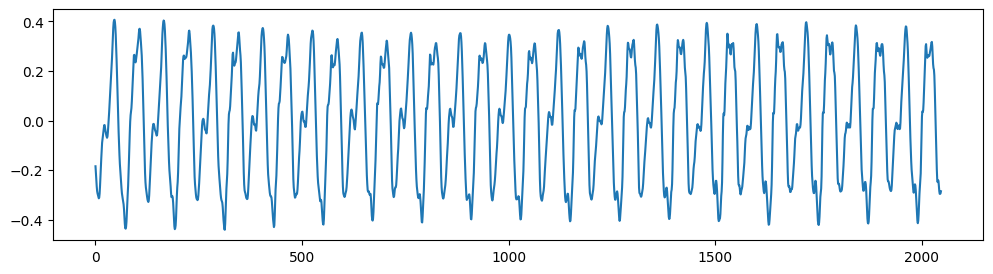

In [3]:
i1 = int(sr*31)
frame = 4096
win = frame//2
xf = x[i1:i1+frame]
plt.figure(figsize=(12, 3))
plt.plot(xf[0:win])

In [4]:
ipd.HTML(inline_compressed_audio(np.concatenate([xf]*10), sr))

In [5]:
# (44100 samples / sec) * (1 cycle / 60 samples)
# (44100/60) (cycles / sec)
T = 120 # Period, in samples
f = sr / T
t = np.arange(sr*2)/sr
y = np.cos(2*np.pi*f*t)
ipd.HTML(inline_compressed_audio(y, sr))

## $f = 440 2 ^ {p/12}$

## $ p = 12 \log_2(f/440) $

In [6]:
12*np.log2(f/440)

np.float64(-3.1171112856111947)

### $r_w[k] = \sum_{n=0}^{w-1} x_f[n] x_f[n + k]$

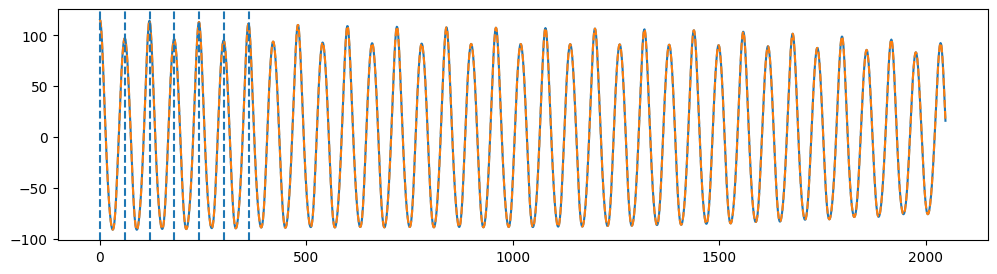

In [7]:
def autocorr_naive(xf):
    """
    Given xf of length frame
    O(frame^2)
    """
    frame = xf.size
    win = frame//2
    r = np.zeros(win+1)
    for k in range(win+1):
        r[k] = np.sum(xf[0:win] * xf[k:k+win])
    return r

def autocorr(xf):
    """
    Given xf of length frame
    O(frame log(frame))
    """
    win = xf.size//2
    a = np.fft.rfft(xf)
    b = np.fft.rfft(xf[0:win], xf.size) # Deal with zeropadding with window in frame
    r = np.fft.irfft(a*np.conj(b)) # Deal with flip compared to convolution
    return r[0:win+1]

plt.figure(figsize=(12, 3))
plt.plot(autocorr_naive(xf))
plt.plot(autocorr(xf), c='C1', linestyle='--')
for k in range(0, 400, 60):
    plt.axvline(k, linestyle='--', c='C0')
#plt.legend(["Naive $O(f^2)$ method", "$O(f \\log f)$ Fourier Method"])

### Framing

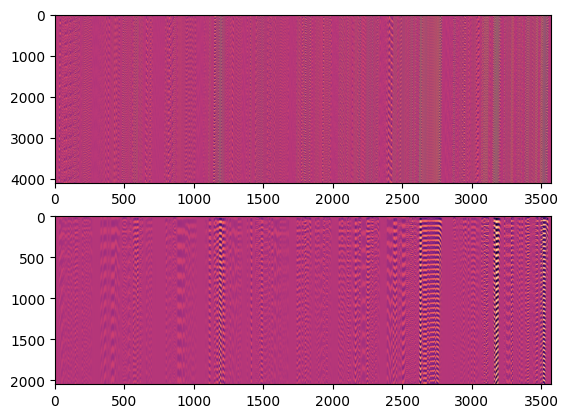

In [8]:
def frame_audio(x, frame, hop):
    """
    x: ndarray(N)
        Audio
    frame: int
        Frame length
    hop: int
        The number of samples to advanced from one frame to the next
    """
    n_frames = 1 + (x.size - frame)//hop
    F = np.zeros((frame, n_frames))
    for j in range(n_frames):
        F[:, j] = x[j*hop:j*hop+frame]
    return F

def autocorr(F):
    win = F.shape[0]//2
    a = np.fft.rfft(F, axis=0)
    b = np.fft.rfft(F[0:win, :], F.shape[0], axis=0) # Deal with zeropadding with window in frame
    R = np.fft.irfft(a*np.conj(b), axis=0) # Deal with flip compared to convolution
    return R[0:win+1, :]

hop = 512
F = frame_audio(x, frame, hop)
R = autocorr(F)
plt.subplot(211)
plt.imshow(np.sign(F)*np.abs(F)**0.5, aspect='auto', cmap='magma')
plt.subplot(212)
plt.imshow(np.sign(R)*np.abs(R)**0.5, aspect='auto', cmap='magma')

## YIN

### $y_w[k] = \sum_{n=0}^{w-1} (x_f[n] - x_f[n + k])^2$

### $y_w[k] = \sum_{n=0}^{w-1} x_f[n]^2 + \sum_{n=0}^{w-1} x_f[n + k]^2 - 2 \sum_{n=0}^{w-1}x_f[n]x_f[n + k] $


### $y_w'[k] = \left\{  \begin{array}{cc} 1 & k = 0 \\ \frac{k y_w[k]}{\sum_{j=1}^{k} y_w[k]} & \text{otherwise} \end{array} \right\}$

In [9]:
fmin = 50
fmax = 2000
TMin = int(np.floor(sr/fmax))
TMax = int(np.ceil(sr/fmin))

## Step 1: Do autocorrelation
win = F.shape[0]//2
a = np.fft.rfft(F, axis=0)
b = np.fft.rfft(F[0:win, :], F.shape[0], axis=0) # Deal with zeropadding with window in frame
R = np.fft.irfft(a*np.conj(b), axis=0) # Deal with flip compared to convolution
R = R[0:win+1, :]

## Step 2: Compute windowed energy
E = np.concatenate((np.zeros((1, F.shape[1])), F), axis=0)
E = np.cumsum(E**2, axis=0) # Discrete version of an integral
E = E[win:, :] - E[0:-win, :]

## Step 3: Compute YIN
Y = E[0:1, :] + E - 2*R

## Step 4: Compute cumulative mean normalization
eps = 1e-7
YNC = np.cumsum(Y[1:, :], axis=0)
YNC[YNC < eps] = eps
YN = np.ones_like(Y)
YN[1:, :] = Y[1:, :]*np.arange(1, YN.shape[0])[:, None] / YNC

In [10]:
Ts = np.argmin(YN, axis=0)
Ts[Ts <= 0] = 1
freqs = sr/Ts

In [11]:
def sonify_freqs(freqs, x, hop, sr, use_rms = True):
    # Make nans the zero frequency
    freqs = np.array(freqs)
    freqs[np.isnan(freqs)] = 0
    # Every freq estimate takes up hop samples
    freqs = (freqs[:, None]*np.ones((1, hop))).flatten() 
    
    t = np.arange(sr*2)/sr
    phase = np.cumsum(freqs/sr)
    y = np.cos(2*np.pi*phase)

    if use_rms:
        rms = np.cumsum(x**2)
        rms = rms[hop:] - rms[0:-hop]
        rms[rms < 0] = 0
        rms = np.sqrt(rms/hop)
        N = min(rms.size, y.size)
        y = y[0:N]*rms[0:N]
    return y

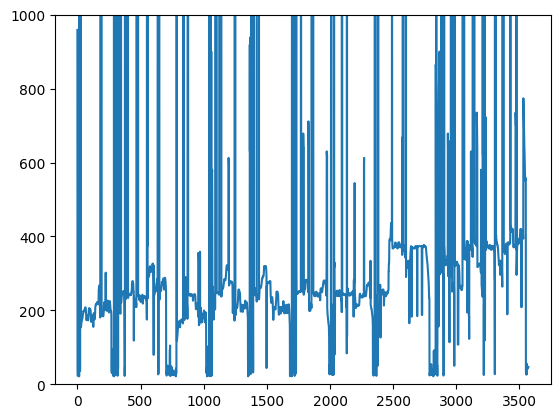

In [12]:
plt.plot(freqs)
plt.ylim([0, 1000])

y = sonify_freqs(freqs, x, hop, sr)
ipd.display(ipd.HTML(inline_compressed_audio(x, sr)))
ipd.display(ipd.HTML(inline_compressed_audio(y, sr)))

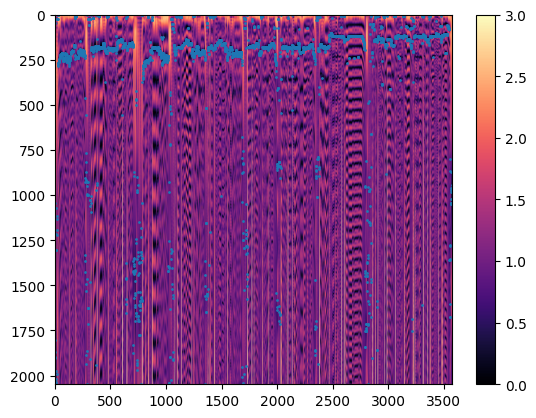

In [13]:
plt.imshow(YN, aspect='auto', cmap='magma', vmin=0, vmax=3)
plt.colorbar()
plt.scatter(np.arange(YN.shape[1]), Ts, s=1)

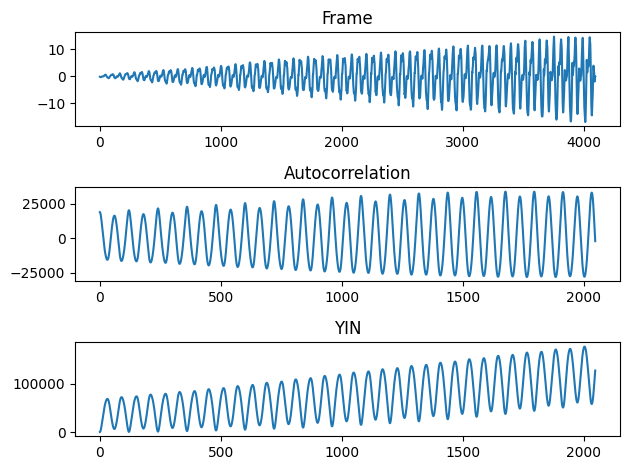

In [14]:
i1 = int(sr*31)
frame = 4096
win = frame//2
xf = x[i1:i1+frame]*(1 + np.arange(xf.size)/100)

a = np.fft.rfft(xf)
b = np.fft.rfft(xf[0:win], frame, axis=0) # Cut out only window length and zeropad
acf = np.fft.irfft(a*np.conj(b), axis=0)[0:win+1]
acf[np.abs(acf) < 1e-6] = 0

e = np.concatenate((np.zeros(1), xf))
e = np.cumsum(e**2)
e = e[win:] - e[0:-win]
y = e[0] + e - 2*acf

plt.subplot(311)
plt.plot(xf)
plt.title("Frame")
plt.subplot(312)
plt.plot(acf)
plt.title("Autocorrelation")
plt.subplot(313)
plt.plot(y)
plt.title("YIN")
plt.tight_layout()

Encapsulating it all in a method...

In [15]:
def get_yin(x, frame, hop, sr, fmin=50, fmax=2000):
    """
    Compute a set of frequency candidates using yin

    Parameters
    ----------
    x: ndarray(N)
        Audio samples
    frame: int
        Length of each analysis frame
    hop: int
        Hop between frames
    sr: int
        Sample rate
    fmin: float
        Minimum frequency to consider (in hz)
    fmax: float
        Maximum frequency to consider (in hz)
    
    Returns
    -------
    freqs: ndarray(n_frames)
        Frequency estimates at each frame
    all_freqs: list of n_frames lists of [float, float] 
        List of of each frequency at a different YIN value for each 
        time window.  For instance, freqs[0] is a list of all 
        [freq, yin] frequencies at different YIN values at the
        first time instant
    """
    TMin = int(np.floor(sr/fmax))
    TMax = int(np.ceil(sr/fmin))
    ## Step 0: Frame audio
    F = frame_audio(x, frame, hop)
    
    ## Step 1: Do autocorrelation
    win = F.shape[0]//2
    a = np.fft.rfft(F, axis=0)
    b = np.fft.rfft(F[0:win, :], F.shape[0], axis=0) # Deal with zeropadding with window in frame
    R = np.fft.irfft(a*np.conj(b), axis=0) # Deal with flip compared to convolution
    R = R[0:win+1, :]
    
    ## Step 2: Compute windowed energy
    E = np.concatenate((np.zeros((1, F.shape[1])), F), axis=0)
    E = np.cumsum(E**2, axis=0) # Discrete version of an integral
    E = E[win:, :] - E[0:-win, :]
    
    ## Step 3: Compute YIN
    Y = E[0:1, :] + E - 2*R
    
    ## Step 4: Compute cumulative mean normalization
    eps = 1e-7
    YNC = np.cumsum(Y[1:, :], axis=0)
    YNC[YNC < eps] = eps
    YN = np.ones_like(Y)
    YN[1:, :] = Y[1:, :]*np.arange(1, YN.shape[0])[:, None] / YNC
    
    ## Step 5: Refine estimates with parabolic interpolation
    left = Y[TMin-1:TMax, :]
    center = Y[TMin:TMax+1, :]
    right = Y[TMin+1:TMax+2, :]
    a = (right + left)/2 - center
    b = (right - left)/2
    a[a == 0] = 1 ## This line was wrong in the video!
    offsets = -b/(2*a)
    offsets[offsets < -1] = 0
    offsets[offsets > 1] = 0
    
    ## Step 6: Extract all mins in a particular range
    T = np.arange(TMin, TMax+1)[:, None]*np.ones((1, YN.shape[1])) + offsets
    is_min = (center < left)*(center < right)
    all_freqs = []
    freqs = np.nan*np.zeros(YN.shape[1])
    for t in range(YN.shape[1]):
        freqst = sr/T[is_min[:, t], t]
        ynt = YN[TMin:TMax+1, :][is_min[:, t], t]
        freqst = freqst[(ynt >= 0)*(ynt <= 1)]
        ynt = ynt[(ynt >= 0)*(ynt <= 1)]
        all_freqs.append(list(zip(freqst, ynt)))
        if freqst.size > 0:
            freqs[t] = freqst[np.argmin(ynt)]
            
    return freqs, all_freqs

## Probabalistic YIN

Text(0.5, 1.0, 'YIN Frequency Estimates')

<Figure size 1500x600 with 0 Axes>

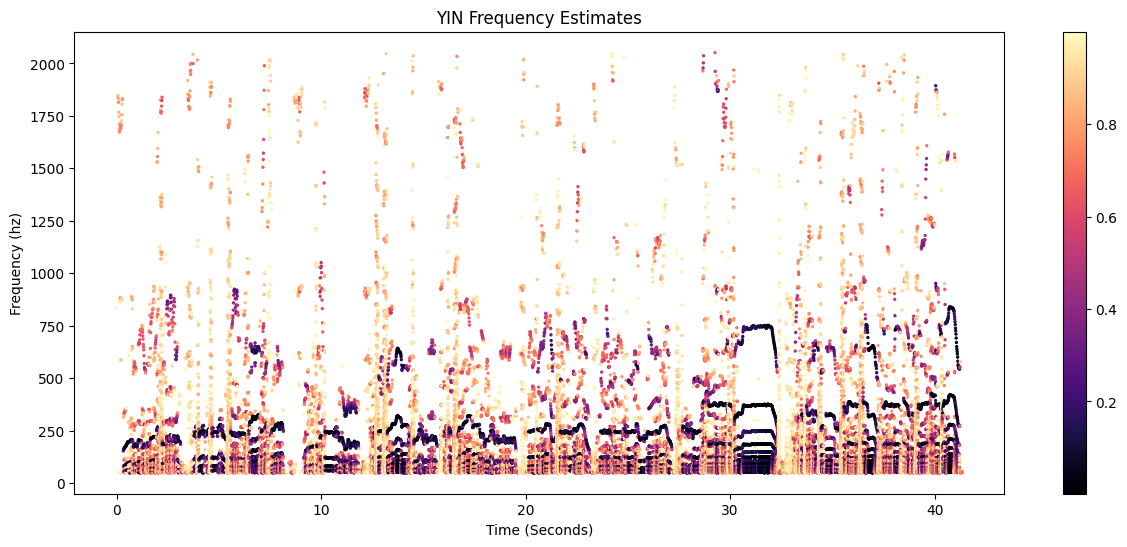

In [16]:
_, all_freqs = get_yin(x, frame, hop, sr)

plt.figure(figsize=(15, 6))
X = []
for t, freqs_t in enumerate(all_freqs):
    for (f, thresh) in freqs_t:
        X.append([t, f, thresh])
X = np.array(X)
plt.figure(figsize=(15, 6))
plt.scatter(X[:, 0]*hop/sr, X[:, 1], s=2, c=X[:, 2], cmap='magma')
plt.colorbar()
plt.xlabel("Time (Seconds)")
plt.ylabel("Frequency (hz)")
plt.title("YIN Frequency Estimates")

## State Space

fmax = fmin*(spacing^K)

log(fmax/fmin) = K log(spacing)

K = log(fmax/fmin)/log(spacing)


## Transition Model

<img src = "TransitionProb.svg">

### $ p_{\text{trans}}(x_t = j | x_{t-1} = k) = \left\{ \begin{array}{cc} \frac{1}{df} - \frac{|j-k|}{df^2} & k > j-df, k < j+df \\ 0 & \text{otherwise} \end{array} \right\} $

### $ p_s = 0.99$ (probability that I stay in voiced/unvoiced)


#### $ p_{\text{transall}}(x_t = j | x_{t-1} = k) = \left\{ \begin{array}{cc} p_s p_{\text{trans}}(x_t = j | x_{t-1} = k) & k > j-df, k < j+df \\ (1-p_s) p_{\text{trans}}(x_t = j-K | x_{t-1} = k) & k > j-K-df, k < j-K+df \\ \\ (1-p_s) p_{\text{trans}}(x_t = j | x_{t-1} = k-K) & k-K > j-df, k-K < j+df \\ 0 & \text{otherwise} \end{array} \right\} $

Text(0.5, 0, 'Index $j$')

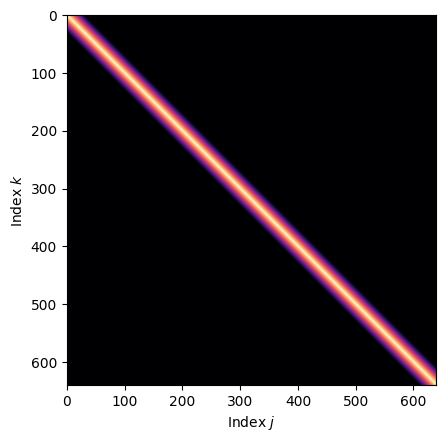

In [17]:
df = 30
spacing = 2**(1/120)
K = int(np.round(np.log(fmax/fmin) / np.log(spacing)))+1
ks = np.arange(K) # 0, 1, ..., K-1
dindex = np.abs(ks[:, None] - ks[None, :])
ptrans = 1/df - dindex/df**2
ptrans[dindex > df] = 0
plt.imshow(ptrans, cmap='magma')
plt.ylabel("Index $k$")
plt.xlabel("Index $j$")

## Observation Model

Given $N$ estimates from NYIN $(f_i, y_i)$, let $k_i$ be the nearest frequency
state in our state space to $f_i$.  Then the observation probability of $k_i$ is

### $p_{o, k_i} = 2^{-y_i/\mu} / N$

The sum of all such probabilities is at most 1.  Distribute the leftover probability
to the unvoiced states

### $p_{o, l} = 1 - \sum_{i}  2^{-y_i/\mu} / N $




So each unvoiced state gets the same probability $p_{o,l}/K$

### Implementing PYIN

In [18]:
def get_pyin(x, frame, hop, sr, mu=0.1, ps=0.99, spacing = 2**(1/120), df=30, fmin=50, fmax=2000, is_causal=False):
    """
    Compute fundamental frequency trajectories using probabalistic YIN

    Parameters
    ----------
    x: ndarray(N)
        Audio samples
    frame: int
        Length of each analysis frame
    hop: int
        Hop between frames
    sr: int
        Sample rate
    mu: float
        Hyperparameter for observations
    ps: float in [0, 1]
        Probability of staying in voiced or unvoiced
    spacing: float
        Multiplicative spacing between adjacent frequency states
    df: int
        Maximum state jump from one frame to the next
    fmin: float
        Minimum frequency to represent, in hz
    fmax: float
        Maximum frequency to reprezent, in hz
    is_causal: bool
        If False, do Viterbi
        If True, do Bayes filter

    Returns
    -------
    B: ndarray(n_states, n_frames)
        Dynamic programming accumulated probability matrix
    L: ndarray(n_states, n_frames)
        Indices that achieved the optimal states
    freqs: 
    """
    ## Step 0: Compute YIN
    _, all_freqs_yin = get_yin(x, frame, hop, sr)
    
    ## Step 1: Figure out state space
    K = int(np.round(np.log(fmax/fmin) / np.log(spacing)))+1
    f_states = fmin*(spacing**(np.arange(K)))
    
    ks = np.arange(K) # 0, 1, ..., K-1
    dindex = np.abs(ks[:, None] - ks[None, :])
    ptrans = np.zeros((K, K))
    ptrans[dindex < df] = np.log(1/df - dindex[dindex < df]/df**2)
    ptrans[dindex >= df] = -np.inf
    
    ## Step 2: Define Viterbi matrices 
    n_times = len(all_freqs_yin)
    L = -np.inf*np.ones((2*K, n_times)) # Accumulated probabilities
    B = np.zeros((2*K, n_times), dtype=int) # Matrix of best preceding state index
    LLast = np.zeros(2*K) ## Prior log probability

    freqs = []
    ## Step 3: Accumulate probabilites over every time
    for t in tqdm(range(n_times)):
        ## Step 3a: Determine active states and compute observation probabilities
        all_freqs = all_freqs_yin[t]
        N = len(all_freqs)
    
        ## Grab the indices of the nearest frequency for all of the yin estimates
        js = np.zeros(N, dtype=int)
        po = np.zeros(N)
        for i, (fi, yi) in enumerate(all_freqs):
            # log(fmax/fmin)/log(spacing)
            j = int(np.round(np.log(fi/fmin)/np.log(spacing)))
            js[i] = max(0, min(j, K-1))
            po[i] = 2**(-yi/mu)/N
        
        ## Step 3b: Update voiced state probabilities
        ## Step 3b.1 Voiced to voiced
        ## NOTE: log(a*b) = log(a) + log(b)
        pVV = LLast[0:K][:, None] + ptrans[:, js] + np.log(ps)
        LVV = np.max(pVV, axis=0) # Best probability for each state j we can get to
        BVV = np.argmax(pVV, axis=0) # Remember the state k that achieved this optimumum
        ## Step 3b.2 Unvoiced to voiced
        pUV = LLast[K:][:, None] + ptrans[:, js] + np.log(1-ps)
        LUV = np.max(pUV, axis=0) # Best probability for each state j we can get to
        BUV = np.argmax(pUV, axis=0) + K # Remember the state k that achieved this optimumum
        
        L[js, t] = np.maximum(LVV, LUV) + np.log(po)
        B[js, t] = BVV
        B[js[LUV > LVV], t] = BUV[LUV > LVV]
    
        ## Step 3c: Update unvoiced state probabilities
        pol = (1 - np.sum(po)) / K # Equally distribute leftover obs prob
        ## Step 3c.1 Unvoiced to unvoiced
        pUU = LLast[K:][:, None] + ptrans + np.log(ps)
        LUU = np.max(pUU, axis=0) # Best probability for each state j we can get to
        BUU = K + np.argmax(pUU, axis=0) # Remember the state k that achieved this optimumum
        ## Step 3c.2 Voiced to unvoiced
        pVU = LLast[0:K][:, None] + ptrans + np.log(1-ps)
        LVU = np.max(pVU, axis=0) # Best probability for each state j we can get to
        BVU = np.argmax(pVU, axis=0) # Remember the state k that achieved this optimumum
        
        L[K:, t] = np.maximum(LUU, LVU) + np.log(pol)
        idx = BUU
        idx[LVU > LUU] = BVU[LVU > LUU]
        B[K:, t] = idx
        
        LLast = L[:, t]
        if is_causal:
            freqs.append(np.argmax(LLast))

    ## Step 4: Do backtracing to find optimal frequency trajectory
    if not is_causal:
        k = np.argmax(LLast)
        t = n_times - 1
        while t >= 0:
            k = B[k, t]
            freqs.append(k)
            t -= 1
        freqs = freqs[::-1]
    freqs = np.array(freqs)
    freqs_ret = np.zeros(n_times)
    freqs_ret[freqs >= K] = np.nan
    freqs_ret[freqs < K] = f_states[freqs[freqs < K]]
    return B, L, freqs_ret

In [19]:
x, sr = librosa.load("brendancher.m4a", sr=44100, mono=False)
x = x[0, :]
B, L, freqs_pyin = get_pyin(x, frame, hop, sr)
B, L, freqs_pyin_causal = get_pyin(x, frame, hop, sr, is_causal=True)

/tmp/ipykernel_13945/2031672098.py:1: UserWarning: PySoundFile failed. Trying audioread instead.
  x, sr = librosa.load("brendancher.m4a", sr=44100, mono=False)
/home/ctralie/miniconda3/lib/python3.13/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
100%|██████████████████████████████████████| 3571/3571 [00:08<00:00, 425.28it/s]


Text(0.5, 0, 'Time frame index')

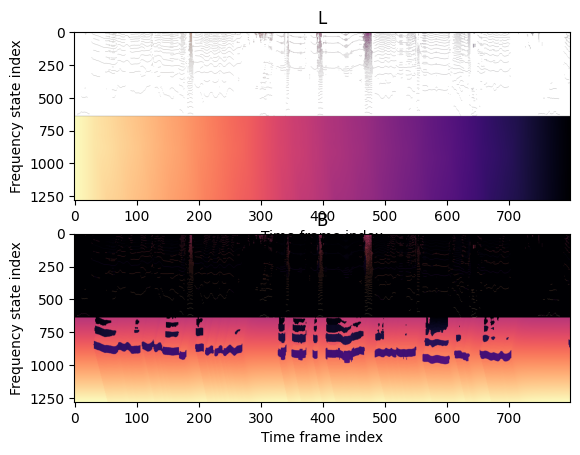

In [20]:
plt.subplot(211)
plt.imshow(L[:, 0:800], cmap='magma', aspect='auto')
plt.title("L")
plt.ylabel("Frequency state index")
plt.xlabel("Time frame index")
plt.subplot(212)
plt.imshow(B[:, 0:800], cmap='magma', aspect='auto')
plt.title("B")
plt.ylabel("Frequency state index")
plt.xlabel("Time frame index")

In [21]:
freqs_yin, _ = get_yin(x, frame, hop, sr) # Get ordinary YIN for comparison

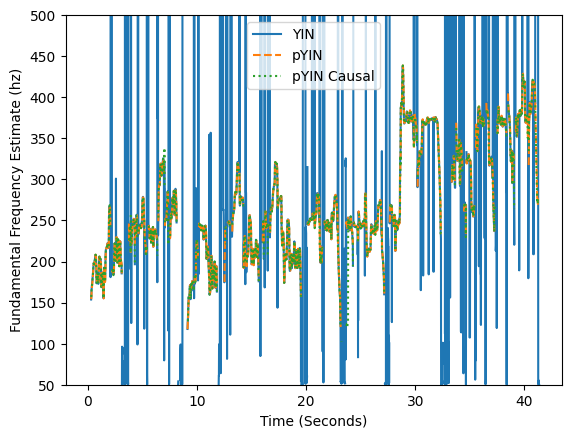

In [22]:
plt.plot(hop*np.arange(freqs_yin.size)/sr, freqs_yin)
plt.plot(hop*np.arange(freqs_pyin.size)/sr, freqs_pyin, linestyle='--')
plt.plot(hop*np.arange(freqs_pyin_causal.size)/sr, freqs_pyin_causal, linestyle=':')
plt.ylim([50, 500])
plt.xlabel("Time (Seconds)")
plt.ylabel("Fundamental Frequency Estimate (hz)")
plt.legend(["YIN", "pYIN", "pYIN Causal"])
ipd.display(ipd.HTML(inline_compressed_audio(x, sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs(freqs_yin, x, hop, sr, use_rms=False), sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs(freqs_pyin, x, hop, sr, use_rms=False), sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs(freqs_pyin_causal, x, hop, sr, use_rms=False), sr)))

Yellow submarine cover!

In [23]:
xsub, sr = librosa.load("submarine.mp3", sr=44100)
freqs_yin_sub, _ = get_yin(xsub, frame, hop, sr)
_, _, freqs_pyin_sub = get_pyin(xsub, frame, hop, sr)
_, _, freqs_pyin_causal_sub = get_pyin(xsub, frame, hop, sr, is_causal=True)

100%|██████████████████████████████████████| 2865/2865 [00:06<00:00, 458.96it/s]


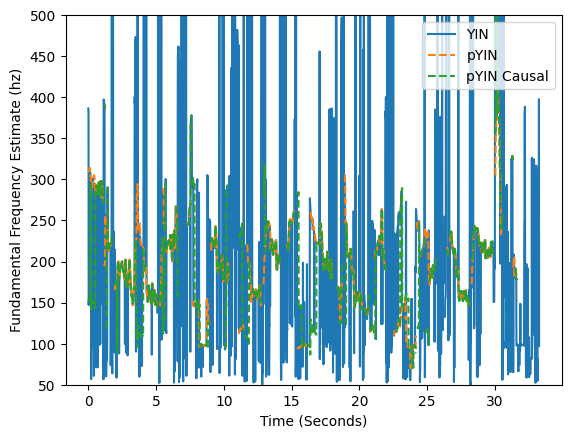

In [24]:
plt.plot(hop*np.arange(freqs_yin_sub.size)/sr, freqs_yin_sub)
plt.plot(hop*np.arange(freqs_pyin_sub.size)/sr, freqs_pyin_sub, linestyle='--')
plt.plot(hop*np.arange(freqs_pyin_causal_sub.size)/sr, freqs_pyin_causal_sub, linestyle='--')
plt.ylim([50, 500])
plt.xlabel("Time (Seconds)")
plt.ylabel("Fundamental Frequency Estimate (hz)")
plt.legend(["YIN", "pYIN", "pYIN Causal"])
ipd.display(ipd.HTML(inline_compressed_audio(xsub, sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs(freqs_yin_sub, xsub, hop, sr, use_rms=False), sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs(freqs_pyin_sub, xsub, hop, sr, use_rms=False), sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs(freqs_pyin_causal_sub, x, hop, sr, use_rms=False), sr)))

## Applications

### Basic FM Synthesis

In [25]:
def sonify_freqs_fm(freqs, x, hop, sr, I=1, ratio=1, use_rms=True):
    # Make nans the zero frequency
    freqs = np.array(freqs)
    freqs[np.isnan(freqs)] = 0
    # Every freq estimate takes up hop samples
    freqs = (freqs[:, None]*np.ones((1, hop))).flatten() 

    A = np.ones(freqs.size)
    if use_rms:
        rms = np.cumsum(x**2)
        rms = rms[hop:] - rms[0:-hop]
        rms[rms < 0] = 0
        A = np.sqrt(rms/hop)
        if x.size > 4*sr:
            # Normalize loudness in a longer window
            rms = np.cumsum(x**2)
            rms = (rms[4*sr:] - rms[0:-4*sr])/(4*sr)
            rms[rms < 0] = 0
            rms = np.sqrt(rms)
            rms = np.concatenate((rms, rms[-1]*np.ones(A.size-rms.size)))
            A = A/rms
        A = A/np.max(A)
        
        N = min(A.size, freqs.size)
        freqs = freqs[0:N]
        A = A[0:N]
    
    t = np.arange(sr*2)/sr
    phase = np.cumsum(freqs/sr)
    y = A*np.cos(2*np.pi*phase + I*A*np.cos(2*np.pi*phase*ratio))

    return y

ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs_fm(freqs_pyin, x, hop, sr, I=0, use_rms=False), sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs_fm(freqs_pyin, x, hop, sr, ratio=1, I=10, use_rms=True), sr)))
ipd.display(ipd.HTML(inline_compressed_audio(sonify_freqs_fm(freqs_pyin, x, hop, sr, ratio=1.4, I=10, use_rms=True), sr)))

### Autotuning

Using R2 (faster) engine
Using crispness level: 5 (Crisp monophonic instrumental)
Read 3571 line(s) from frequency map file
Using time ratio 1 and initial frequency ratio 1
80% NOTE: Clipping detected at output sample 1470565, restarting with reduced gain of 0.99837 (supply --ignore-clipping to avoid this)
97% NOTE: Clipping detected at output sample 1788346, restarting with reduced gain of 0.926906 (supply --ignore-clipping to avoid this)
    
in: 1831936, out: 1831936, ratio: 1, ideal output: 1831936, error: 0
elapsed time: 6.00133 sec, in frames/sec: 305254, out frames/sec: 305254


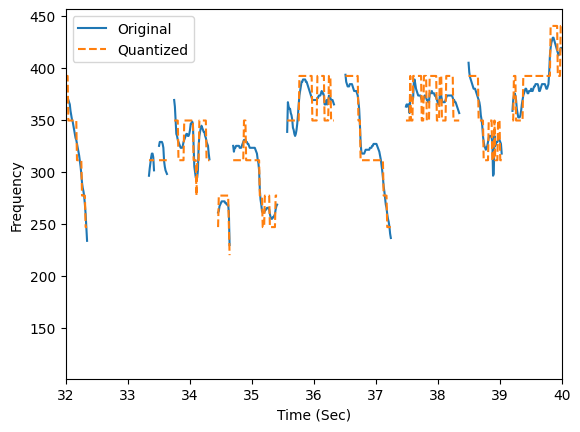

In [26]:
import subprocess
def quantize_freqs(freqs, fref = 440, spacing=2**(1/12)):
    from scipy.signal import medfilt
    ## freqs = fref * (spacing**ks)
    ks = np.round(np.log(freqs/fref) / np.log(spacing))
    #wiggle = np.random.randint(-1, 2, ks.size)
    #wiggle = medfilt(wiggle, 15)
    #ks += wiggle
    return fref * (spacing**ks)

times = hop*np.arange(freqs_yin.size)/sr
qfreq = quantize_freqs(freqs_pyin, spacing=2**(2/12))

ratio = qfreq / freqs_pyin
ratio[np.isnan(ratio)] = 1 # Don't do anything for unvoiced
with open("ratios.txt", "w") as fout:
    for i, r in enumerate(ratio):
        fout.write(f"{i*hop} {r}\n")

!rubberband brendancher.wav warped.wav --freqmap ratios.txt
plt.plot(times, freqs_pyin)
plt.plot(times, qfreq, linestyle='--')
plt.xlabel("Time (Sec)")
plt.xlim([32, 40])
plt.ylabel("Frequency")
plt.legend(["Original", "Quantized"])

In [27]:
xwarp, _ = librosa.load("warped.wav", sr=sr)
ipd.HTML(inline_compressed_audio(xwarp, sr))

### Autotuning to one note

In [28]:
f = 330
t = np.arange(sr)/sr
y = np.cos(2*np.pi*f*t)
ipd.Audio(y, rate=sr)

In [29]:
ratio = f / freqs_pyin
ratio[np.isnan(ratio)] = 1 # Don't do anything for unvoiced
with open("ratios.txt", "w") as fout:
    for i, r in enumerate(ratio):
        fout.write(f"{i*hop} {r}\n")
!rubberband brendancher.wav warped.wav --freqmap ratios.txt
xwarp, _ = librosa.load("warped.wav", sr=sr)
ipd.HTML(inline_compressed_audio(xwarp, sr))

Using R2 (faster) engine
Using crispness level: 5 (Crisp monophonic instrumental)
Read 3571 line(s) from frequency map file
Using time ratio 1 and initial frequency ratio 1
97% NOTE: Clipping detected at output sample 1788850, restarting with reduced gain of 0.956833 (supply --ignore-clipping to avoid this)
98% NOTE: Clipping detected at output sample 1804284, restarting with reduced gain of 0.94834 (supply --ignore-clipping to avoid this)
98% NOTE: Clipping detected at output sample 1804745, restarting with reduced gain of 0.942024 (supply --ignore-clipping to avoid this)
    
in: 1831936, out: 1831936, ratio: 1, ideal output: 1831936, error: 0
elapsed time: 10.5733 sec, in frames/sec: 173260, out frames/sec: 173260
